# Main Script to Load, Transform and Analyse data for Final Assigment

## Data load from local file "HM Land Registry - Price Paid Data property sales in Greater London - Raw Data.csv"

# Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import locale # Used 
import chardet # File london-borough-profiles.csv has an unknown encoding type
import yaml # Used to manage configuration Parameters, I'm using it at work and it's so easy to set configurable constant values 

# Loading config file

In [2]:
cnf_file = open(f"config.yaml", 'r')
conf_dictionary = yaml.full_load(cnf_file)
config = conf_dictionary["default"]

# Set the locale to display the currency format
locale.setlocale(locale.LC_ALL, '')

'English_United Kingdom.1252'

# Load data from CSV file

In [3]:
df1 = pd.read_csv("Data\Property sales in Greater London - 2018 - 2019.csv", parse_dates=[config['parse_dates']], dayfirst=False)
df2 = pd.read_csv("Data\Property sales in Greater London - 2020 - 2023.csv", parse_dates=[config['parse_dates']], dayfirst=True)
with open("Data\london-borough-profiles.csv", 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

df3 = pd.read_csv("Data\london-borough-profiles.csv", encoding=result['encoding'])

# The below file was created manually researching how can each of the boroughs be categorized geographycally 
# according to their location relative to the River Thames (5 Categories [North London, Inner London, East London, South London, West London])
df4 = pd.read_csv("Data\London Boroughs and Location.csv")



### Defining a function to plot graphs easier 

In [4]:
def plot_ts(axes, x, y, color, xlabel, ylabel):
    axes.plot(x, y, color=color)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel, color=color)
    axes.tick_params('y', colors=color)


# Merging both dataframes

In [5]:
df = pd.concat([df1, df2])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489352 entries, 0 to 287274
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   unique_id             489352 non-null  object        
 1   price_paid            489352 non-null  int64         
 2   deed_date             489352 non-null  datetime64[ns]
 3   postcode              488916 non-null  object        
 4   property_type         489352 non-null  object        
 5   new_build             489352 non-null  object        
 6   estate_type           489352 non-null  object        
 7   saon                  183047 non-null  object        
 8   paon                  489352 non-null  object        
 9   street                489312 non-null  object        
 10  locality              31256 non-null   object        
 11  town                  489352 non-null  object        
 12  district              489352 non-null  object        
 13 

# Renaming columns from both DFs

In [6]:
keys   = ['unique_id','price_paid','deed_date','postcode','property_type','new_build','estate_type','saon','paon','street','locality','town','district','county','transaction_category','linked_data_uri']
values = ['Id','Value','Purchased Date','Postcode','Property Type','New Build','Estate Type','Saon','Paon','Street','Locality','Town','District','County','Transaction Category','URL']
dict_cols = dict(zip(keys, values))
df.rename(columns=dict_cols, inplace=True)

### Ordering and Cleansing the data

In [7]:
col_order = ['Id','Purchased Date','Postcode','Property Type','Value','New Build','Estate Type','Transaction Category','Saon','Paon','Street','Locality','Town','District','County','URL']
df = df[col_order]
for col in ['Saon','Paon','Street','Locality','Town','District','County']:
    df[col] = df[col].str.title()
    
# Renaming values on Property Type
property_type_replace = {'D': 'Detached', 'S': 'Semi-Detached', 'T': 'Terraced', 'F': 'Flats/Maisonettes', 'O': 'Other'}
df.replace({"Property Type": property_type_replace}, inplace=True)

# Renaming values on New properties as False, True
df.replace({'New Build': {'Y': True, 'N': False}}, inplace=True)

# Renaming Transaction Category
df.replace({'Transaction Category': {'A': 'Standard Price Paid', 'B': 'Additional Price Paid'}}, inplace=True)

# Renaming Duration tenancy
df.replace({'Estate Type': {'F': 'Freehold', 'L': 'Leasehold'}}, inplace=True)

# Adding Areas values with title style for easier merging
df3['Area'] = df3['Area'].str.title()


# Adding Borough values with title style for easier merging
df4['Borough'] = df4['Borough'].str.title()

# Removing properties under £10.000
df = df.drop(df[df.Value <= 10000].index)
# Merging df3 and df4
df3 = pd.merge(df3, df4[['Borough', 'Location']], how="left", left_on='Area', right_on='Borough', copy=True)

# Merging df and df3
df = pd.merge(df, df3[['Area', 'Inner-Outer', 'Population', 'Location']], how="left", left_on='District', right_on='Area', copy=True).drop(columns=['Area'])
# df = pd.merge(df, tempDF, how='left', left_on=["Id"], right_on=['Temp_id'], copy=True).drop(columns=['Temp_id'])

df.to_csv("Property Sales in Greater London - Merged.csv", index=False)

# Explore the data

In [8]:
print("Dataframe shape:")
print(df.shape )

print("Dataframe columns:")
print(df.columns)


Dataframe shape:
(489346, 19)
Dataframe columns:
Index(['Id', 'Purchased Date', 'Postcode', 'Property Type', 'Value',
       'New Build', 'Estate Type', 'Transaction Category', 'Saon', 'Paon',
       'Street', 'Locality', 'Town', 'District', 'County', 'URL',
       'Inner-Outer', 'Population', 'Location'],
      dtype='object')


# Index of Property Market - Yearly Variation

### Convert date column to datetime format, set it as index and create a Year column out of it

In [9]:
df['Purchased Date'] = pd.to_datetime(df['Purchased Date'])
df.set_index('Purchased Date', inplace=True)
df['Year'] = df.index.year
df.index

DatetimeIndex(['2018-11-30', '2019-12-09', '2019-10-16', '2018-11-23',
               '2019-07-05', '2018-08-23', '2019-07-15', '2018-05-10',
               '2018-03-14', '2018-06-08',
               ...
               '2020-01-21', '2020-01-21', '2020-01-21', '2020-01-21',
               '2020-01-21', '2020-01-21', '2020-07-02', '2020-08-28',
               '2021-02-19', '2020-10-30'],
              dtype='datetime64[ns]', name='Purchased Date', length=489346, freq=None)

### Histogram of prices last year

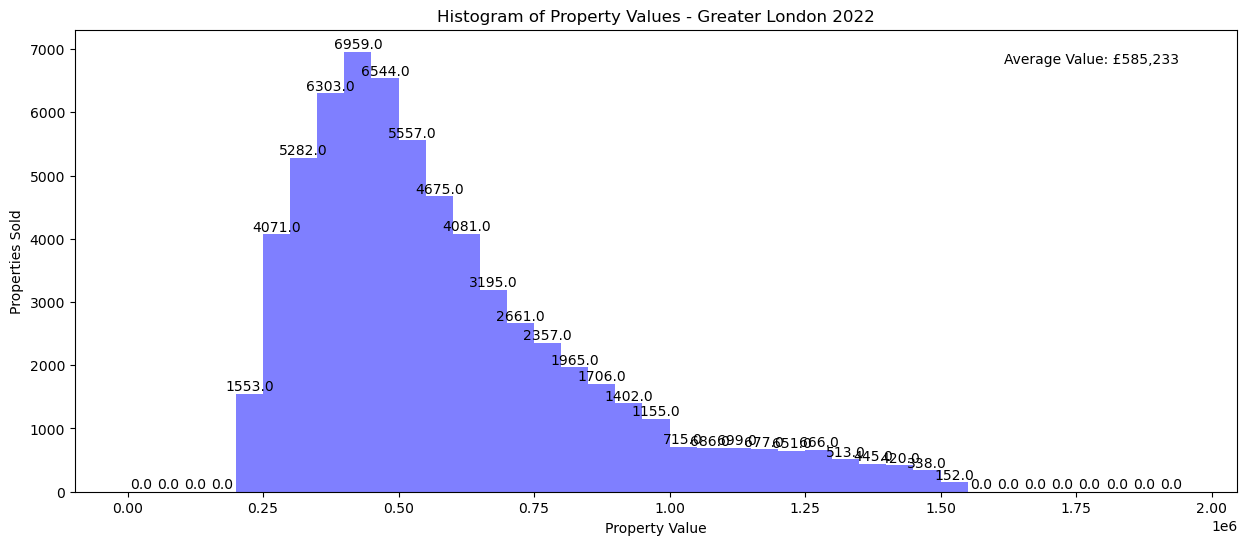

In [19]:
# remove extremely low and high values
value_min = df['Value'].quantile(0.05)
value_max = df['Value'].quantile(0.95)

df_last_year = df.loc['2022-']
df_last_year = df_last_year[(df_last_year['Value'] >= value_min) & (df_last_year['Value'] <= value_max)]
average_value = df_last_year['Value'].mean()
# Calculate the range of property values
value_range = df_last_year['Value'].max() - df_last_year['Value'].min()
# f"{df_last_year['Value'].max()} - {df_last_year['Value'].min()}"

# Plot histogram
fig, ax = plt.subplots(figsize=(15, 6))
n, bins, patches = ax.hist(df_last_year['Value'], bins=range(0, 2000000, 50000), color='blue', alpha=0.5)

# Add annotations
for i in range(len(patches)):
    bin_center = (bins[i] + bins[i+1])/2
    bin_count = n[i]
    ax.annotate(f"{bin_count}", xy=(bin_center, bin_count), ha='center', va='bottom')
    
ax.set_xlabel('Property Value')
ax.set_ylabel('Properties Sold')
ax.set_title('Histogram of Property Values - Greater London 2022')
label = locale.format_string('%.0f', val=average_value, grouping=True, monetary=False)
# Add the range value of the property
ax.text(0.95, 0.95, f"Average Value: {locale.currency(average_value, grouping=True)[:-3]}", transform=ax.transAxes, ha='right', va='top')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


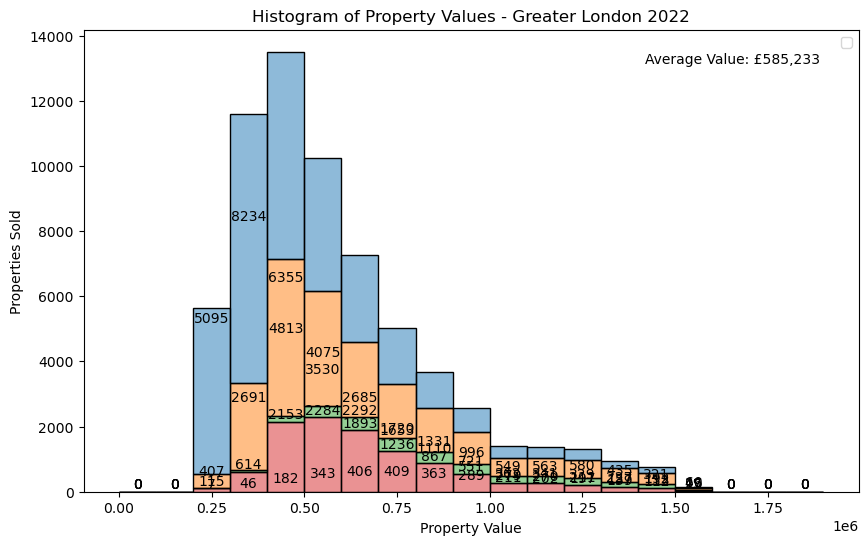

In [21]:

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df_last_year, x='Value', bins=range(0, 2000000, 100000), hue='Property Type', alpha=0.5, multiple='stack')

# Add annotations
for patch in ax.patches:
    bin_center = patch.get_x() + patch.get_width() / 2
    bin_count = patch.get_height()
    ax.annotate(f"{int(bin_count)}", xy=(bin_center, bin_count), ha='center', va='bottom')

ax.legend()
ax.set_xlabel('Property Value')
ax.set_ylabel('Properties Sold')
ax.set_title('Histogram of Property Values - Greater London 2022')
label = locale.format_string('%.0f', val=average_value, grouping=True, monetary=False)
# Add the range value of the property
ax.text(0.95, 0.95, f"Average Value: {locale.currency(average_value, grouping=True)[:-3]}", transform=ax.transAxes, ha='right', va='top')
plt.legend()
plt.show()


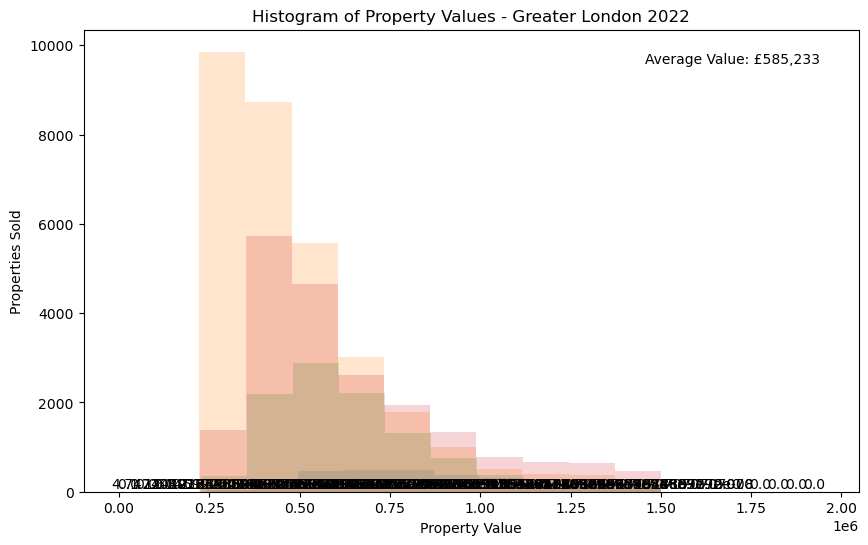

In [12]:
# Group data by Property Type and get range value for each group
property_ranges = df_last_year.groupby('Property Type')['Value'].apply(lambda x: (x.min(), x.max()))

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(df_last_year['Value'], bins=range(0, 2000000, 50000), color='blue', alpha=0.5, density=True)

# Adding colouring according with Property Type
for prop_type in property_ranges.index:
    data = df_last_year.loc[df_last_year['Property Type'] == prop_type, 'Value']
    ax.hist(data, alpha=0.2, label=prop_type)

# Add annotations
for i in range(len(patches)):
    bin_center = (bins[i] + bins[i+1])/2
    bin_count = n[i]
    ax.annotate(f"{bin_count}", xy=(bin_center, bin_count), ha='center', va='bottom')
    
ax.set_xlabel('Property Value')
ax.set_ylabel('Properties Sold')
ax.set_title('Histogram of Property Values - Greater London 2022')
label = locale.format_string('%.0f', val=average_value, grouping=True, monetary=False)
# Add the range value of the property
ax.text(0.95, 0.95, f"Average Value: {locale.currency(average_value, grouping=True)[:-3]}", transform=ax.transAxes, ha='right', va='top')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


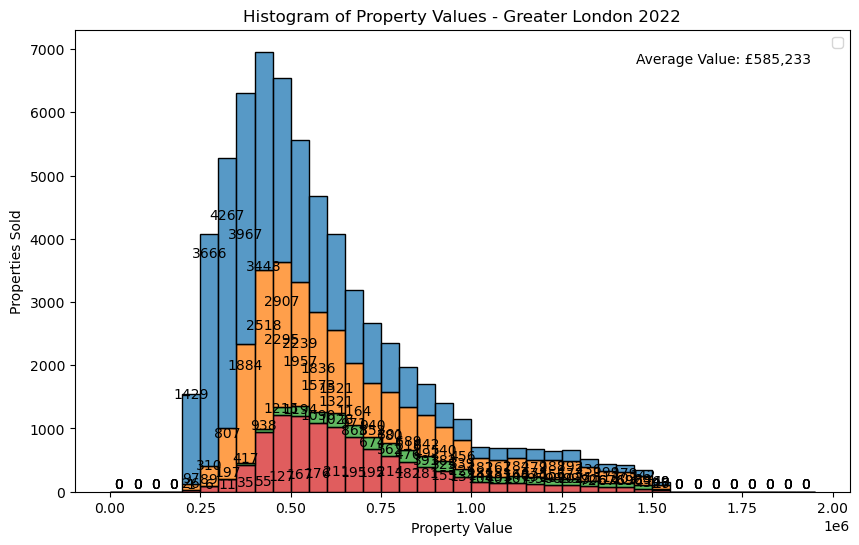

In [26]:

# Group data by Property Type and get range value for each group
property_ranges = df_last_year.groupby('Property Type')['Value'].apply(lambda x: (x.min(), x.max()))

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(data=df_last_year, x='Value', bins=range(0, 2000000, 50000), hue='Property Type', multiple="stack", ax=ax)

# Add annotations
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", xy=(p.get_x() + p.get_width()/2, p.get_height()), ha='center', va='bottom')

ax.legend( loc="upper right") # HELP for Johns, can't display the "Legend"
ax.set_xlabel('Property Value')
ax.set_ylabel('Properties Sold')
ax.set_title('Histogram of Property Values - Greater London 2022')
#  Min and values only
# Add the range value of the property
ax.text(0.95, 0.95, f"Average Value: {locale.currency(average_value, grouping=True)[:-3]}", transform=ax.transAxes, ha='right', va='top')
plt.show()

In [29]:

# Group data by Property Type and get range value for each group
property_ranges = df_last_year.groupby('Property Type')['Value'].apply(lambda x: (x.min(), x.max()))

n, bins, patches = ax.hist(df_last_year['Value'], bins=range(0, 2000000, 50000), color='blue', alpha=0.5)

for prop_type in property_ranges.index:
    data = df_last_year.loc[df_last_year['Property Type'] == prop_type, 'Value']
    ax.hist(data, alpha=1, label=prop_type)
    
# Add annotations for range value of each property type
for prop_type in property_ranges.index:
    x = property_ranges[prop_type]
    ax.annotate(f'{x[0]} - {x[1]}', xy=(x[0], 0), xytext=(x[0], -30), ha='center', va='top',
                arrowprops=dict(facecolor='black', arrowstyle='-|>'))
    
# Add legend and labels
ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Properties Sold')
plt.show()

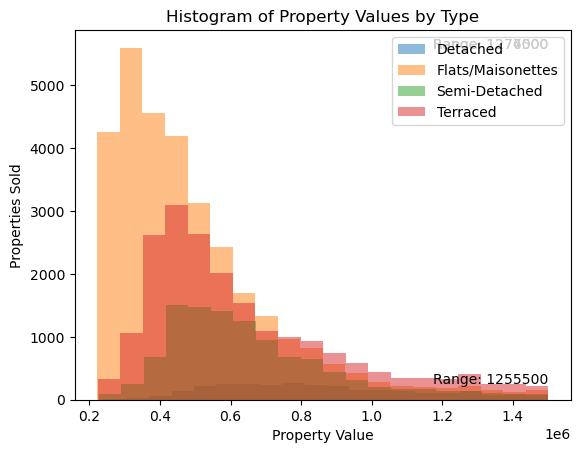

In [23]:

# group by Property Type and calculate the range of property values
grouped = df_last_year.groupby('Property Type')
ranges = grouped['Value'].agg(lambda x: max(x) - min(x))

# create a histogram for each Property Type
for property_type, group in grouped:
    plt.hist(group['Value'], bins=20, alpha=0.5, label=property_type)

    # add an annotation with the range of property values
    x_pos = group['Value'].max()
    y_pos = plt.ylim()[1] * 0.95
    plt.annotate(f'Range: {ranges[property_type]}', (x_pos, y_pos), ha='right')

plt.legend()
plt.xlabel('Property Value')
plt.ylabel('Properties Sold')
plt.title('Histogram of Property Values by Type')
plt.show()

# Line graphs

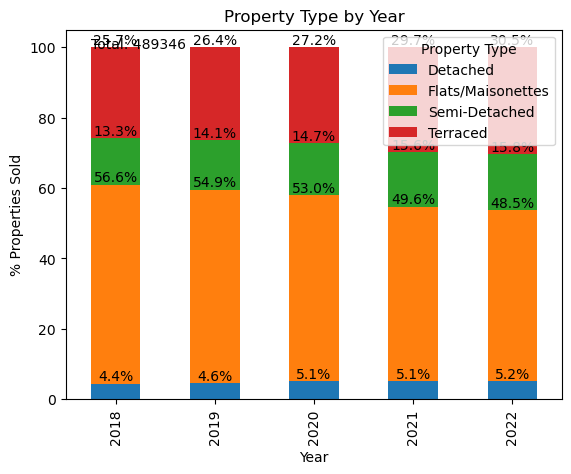

In [27]:
# Group data by year and property type and count the number of properties in each group
# grouped = df.groupby(['Year', 'Property Type'])['Id'].count()
# grouped = df.groupby(['Year', 'Property Type']).agg(count=('Id','count'))

# group the data by year and Property Type
grouped = df.groupby(['Year', 'Property Type']).size().unstack()
grouped
# calculate the percentages
grouped_percent = grouped.apply(lambda x: 100 * x / float(x.sum()), axis=1)

# plot the stacked bar chart
ax = grouped_percent.plot(kind='bar', stacked=True)

# set the title and axis labels
ax.set_title('Property Type by Year')
ax.set_xlabel('Year')
ax.set_ylabel('% Properties Sold')

# annotate the values
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f"{val:.1f}%" for val in i.datavalues])
    
# add the total number of properties    
total = grouped.sum(axis=1)
ax.annotate(f"Total: {total.sum()}", xy=(0.05, 0.95), xycoords='axes fraction')

plt.show()

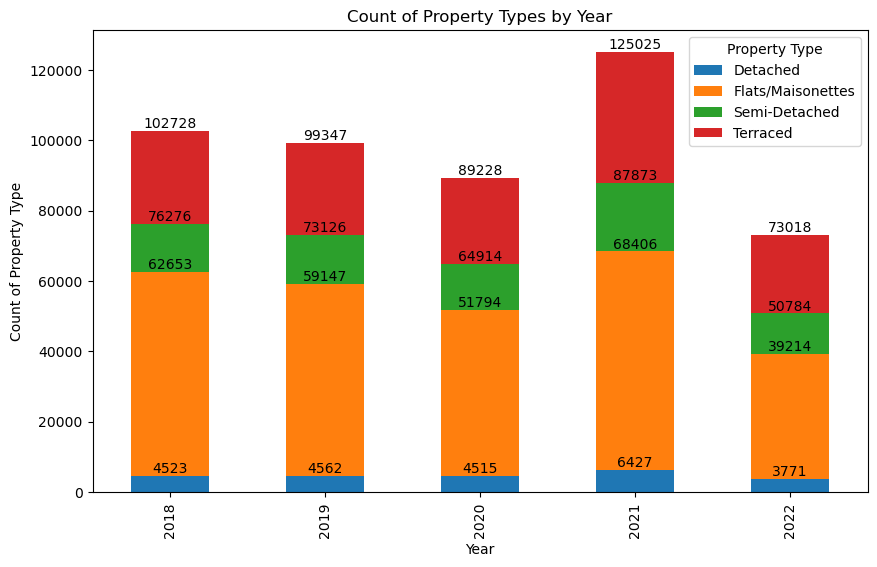

In [17]:
# group the data by 'Year' and 'Property Type', and get the count
df_grouped = df.groupby(['Year', 'Property Type']).size().reset_index(name='Count')

# pivot the data to make 'Property Type' values as columns
df_pivot = df_grouped.pivot(index='Year', columns='Property Type', values='Count')

# plot a stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))

# set the axis Labels and Title
ax.set_xlabel('Year')
ax.set_ylabel('Count of Property Type')
ax.set_title('Count of Property Types by Year')

# annotate the values on the chart
for i in ax.containers:
#     label = locale.format_string('%.0f', val=i, grouping=True, monetary=False)
    ax.bar_label(i, label_type='edge', fontsize=10)

# display the chart
plt.show()

KeyError: 'Purchased Date'

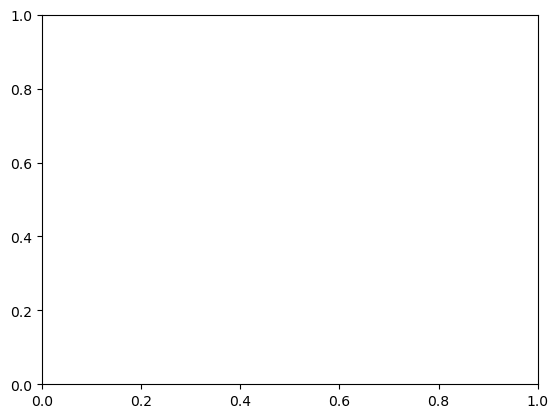

In [18]:
fig, ax = plt.subplots()

ax.plot(df['Purchased Date'].dt.month, )



### Set date column as the index

### Group data by year, aggregate by value and plot this

In [ ]:
# df_avg = df.groupby('Year')['Value'].mean()
# Eg: df.groupby('kind').agg(min_height=('height', 'min'), max_weight=('weight', 'max'))
df_avg = df.groupby('Year').agg(Value=('Value', 'mean'), max=('Value', 'max'), min=('Value', 'min'), count=('Id','count'))

plt.plot(df_avg.index, df_avg['Value'])
plt.xlabel('Year')
plt.ylabel('Avg Property Value')
plt.title('Average Property Value in Greater London for Last 5 years')

# zip joins x and y coordinates in pairs
plt.rcParams.update({'axes.ymargin': 0.2})
plt.rcParams.update({'axes.xmargin': 0.5})
for x,y in zip(df_avg.index, df_avg['Value']):
    label = "{:.0f}".format(y)
    label = locale.currency(y, grouping=True)[:-3]
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 annotation_clip=False) # horizontal alignment can be left, right or center

F = plt.gcf() # To increase the width of the graph.
Size = F.get_size_inches()
# F.set_size_inches(Size[0]*1.2, Size[1]*1, forward=True)
plt.show()

In [ ]:

pct_var = df_avg['count'].pct_change() * 100

plt.plot(df_avg.index, df_avg['count'])
plt.xlabel('Year')
plt.ylabel('# Properties Sold')
plt.title('Property Sales in Greater London for Last 5 years')

# zip joins x and y coordinates in pairs
plt.rcParams.update({'axes.ymargin': 0.2})
plt.rcParams.update({'axes.xmargin': 0.5})
for x,y,var in zip(df_avg.index, df_avg['count'], pct_var):
    label = "{:.0f}".format(y)
    label = locale.format_string('%.0f', val=y, grouping=True, monetary=False)
    plt.annotate(label + '\n' + str(round(var,2)) + '%', # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 annotation_clip=False) # horizontal alignment can be left, right or center

F = plt.gcf() # To increase the width of the graph.
Size = F.get_size_inches()
# F.set_size_inches(Size[0]*1.2, Size[1]*1, forward=True)
plt.show()

In [ ]:

# Group the data
df_avg = df.groupby(['Year', 'Property Type']).agg(Value=('Value', 'mean'), max=('Value', 'max'), min=('Value', 'min'), count=('Id','count')).reset_index()

# Calculate the total count of properties for each year
year_count = df_avg.groupby('Year')['count'].sum().reset_index()

# Merge the total count with the groupby result
df_avg = pd.merge(df_avg, year_count, on='Year')

# Calculate the percentage of each property type
df_avg['Percentage'] = df_avg['count_x'] / df_avg['count_y'] * 100

# Pivot the data to have property types as columns
df_pivot = df_avg.pivot(index='Year', columns='Property Type', values='Percentage')

# Plot the graph
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Percentage')
ax.set_ylim(0, 100)

# Annotate the graph with percentage and count values
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f"{j:.1f}%" for j in i.datavalues], padding=5)

for i in range(len(df_pivot)):
    for j in range(len(df_pivot.columns)):
        value = df_pivot.iloc[i, j]
        # ax.annotate(f"{value:.1f}%", xy=(i, df_pivot.iloc[:i, j].sum() + value / 2), ha='center', va='center', color='white', fontsize=10)
        count = df_avg.loc[(df_avg['Year'] == df_pivot.index[i]) & (df_avg['Property Type'] == df_pivot.columns[j]), 'count_x'].values[0]
        ax.annotate(f"{count} ({value:.1f}%)", xy=(i, df_pivot.iloc[:i, j].sum() + value), ha='center', va='center', color='black', fontsize=8)

plt.show()


In [ ]:
# Group data by Property Type and get range value for each group
property_ranges = df.groupby('Property Type')['Value'].apply(lambda x: (x.min(), x.max()))

# Plot histogram broken by Property Type
fig, ax = plt.subplots()
for prop_type in property_ranges.index:
    data = df.loc[df['Property Type'] == prop_type, 'Value']
    ax.hist(data, alpha=0.5, label=prop_type)
    
# Add annotations for range value of each property type
for prop_type in property_ranges.index:
    x = property_ranges[prop_type]
    ax.annotate(f'{x[0]} - {x[1]}', xy=(x[0], 0), xytext=(x[0], -30), ha='center', va='top',
                arrowprops=dict(facecolor='black', arrowstyle='-|>'))
    
# Add legend and labels
ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
plt.show()


In [ ]:
# your colors
colors = ['#5cb85c', '#5bc0de', '#d9534f']

# plot with annotations is probably easier
p1 = df_avg.plot(kind='bar', use_index=True, color=colors, figsize=(20, 8), rot=0, ylabel='Percentage', title="The percentage of the respondents' interest in the different data science Area")

for p in p1.containers:
    p1.bar_label(p, fmt='%.2f', label_type='edge')

In [ ]:
### Increase in Percentage per year

In [ ]:
fst_avg_price = df_avg.Value.iloc[0]
normalized = df_avg.Val
dogs.groupby(["color","breed"])["weight_kg"].mean()

df_avg = df.Value.div(
    

# Set the locale to display the currency format
locale.setlocale(locale.LC_ALL, '')

plt.plot(df_avg.index, df_avg.values)
plt.xlabel('Year')
plt.ylabel('Avg Property Value')
plt.title('Average Property Value in Greater London for Last 5 years')
# zip joins x and y coordinates in pairs
plt.rcParams.update({'axes.ymargin': 0.2})
plt.rcParams.update({'axes.xmargin': 0.5})
for x,y in zip(df_avg.index, df_avg.values):

    label = "{:.0f}".format(y)
    label = locale.currency(y, grouping=True)[:-3]
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 annotation_clip=False) # horizontal alignment can be left, right or center

F = plt.gcf() # To increase the width of the graph.
Size = F.get_size_inches()
F.set_size_inches(Size[0]*1.2, Size[1]*1, forward=True)
plt.show()

# Aggregate data by Year, District and 

In [ ]:
# group data by year and type and compute the avg of the numeric column
grouped = df.groupby(['Year', 'District']).agg({'Value': 'mean'})
# df.info()

In [ ]:

# reset the index to convert the resulting DataFrame back to a regular format
grouped = grouped.reset_index()

# format the values as currency using applymap
# grouped = grouped.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
grouped["Value"] = grouped.Value.astype(float)
# grouped.info()

In [ ]:
sns.lineplot(x=df["Year"],y=df["Value"],hue=df["District"])
# grouped.plot(x="Year", y="District");

In [ ]:
# plot the resulting DataFrame using seaborn
sns.catplot(x='District', y='Value', hue='Year', kind='bar', data=grouped, height=6, aspect=2)

# set the tick labels to display the formatted currency values
ax = plt.gca()
for i, tick in enumerate(ax.get_yticklabels()):
    tick.set_text(grouped.iloc[i]['Value'])
    ax.set_yticklabels(ax.get_yticklabels())

plt.show()

### Calculate the average of a numeric column for each year